### Ejecución Random Forest

Librerias

In [13]:
import numpy as np
import pandas as pd
import joblib

#Librerias del modelo

from sklearn.ensemble import RandomForestRegressor
#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
#import statsmodels.api as sm
import math
#evaluacion de variables
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Se importa nuestro DataSet Limpio

In [14]:
dataSetCalidadAire = pd.read_csv("data/stage/dataSetLimpio4.csv")

dataSetCalidadAire.head(3)

,anio,mes,dia,pm25,festivo,temperatura,humedad,p1,presion,velocidad_prom,velocidad_max,direccion_prom,direccion_max,dia_semana_Fin de Semana,dia_semana_Inicio Semana,dia_semana_Media semana,estacion_Estacion Aranjuez,estacion_Estacion Belen,estacion_Estacion Caldas
0,2024,1,1,19,1,19,72,0,827,1,1,156,156,0,1,0,0,0,1
1,2024,1,2,12,0,19,76,0,826,1,2,128,130,0,1,0,0,0,1
2,2024,1,3,15,0,17,73,0,826,1,2,155,153,0,1,0,0,0,1


In [15]:
columnasEliminar = ['pm25','anio']
X = dataSetCalidadAire.drop(columns = columnasEliminar)
y = dataSetCalidadAire['pm25']

In [16]:
# División de los datos
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.7, #70 % de nuestros datos en entrenamiento
    random_state=1234,
    shuffle=True
)

In [17]:
columnasModelo = X.columns.tolist()
columnasModelo 
# Llamamos nuestro scaler ya guardado
scaler = joblib.load("data/stage/estandarizacionDataSet2.pkl")
# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[columnasModelo] = scaler.fit_transform(X_train[columnasModelo])
X_test[columnasModelo] = scaler.transform(X_test[columnasModelo])

X_train[columnasModelo].head(3)

,mes,dia,festivo,temperatura,humedad,p1,presion,velocidad_prom,velocidad_max,direccion_prom,direccion_max,dia_semana_Fin de Semana,dia_semana_Inicio Semana,dia_semana_Media semana,estacion_Estacion Aranjuez,estacion_Estacion Belen,estacion_Estacion Caldas
513,0.25,0.433333,0.0,0.833333,0.307692,0.0,0.827586,0.333333,0.4,0.123810,0.111111,0.0,0.0,1.0,0.0,1.0,0.0
569,0.75,0.266667,0.0,0.750000,0.282051,0.0,0.862069,0.000000,0.2,0.387302,0.551971,0.0,1.0,0.0,0.0,1.0,0.0
453,1.00,0.500000,0.0,0.666667,0.256410,0.0,0.896552,0.333333,0.4,0.463492,0.501792,0.0,1.0,0.0,1.0,0.0,0.0


In [18]:
# Creación del modelo
# ==============================================================================
modelRF = RandomForestRegressor(
            n_estimators = 25,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'sqrt',
            oob_score    = False,   #out-of-bag samples
            n_jobs       = -1,
            random_state = 123
         )


# Entrenamiento del modelo
# ==============================================================================
modelRF.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=25, n_jobs=-1,
                      random_state=123)

In [19]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelRF.predict(X = X_test)

rmse = mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 5.338311169046455
El error (r2) de test es: 0.4548776052265183


In [36]:
# Error de train del modelo inicial
# ==============================================================================
predicciones = modelRF.predict(X = X_train)

rmse = mean_squared_error(y_true  = y_train, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_train, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 2.5180523126544316
El error (r2) de test es: 0.8803496703855145


proceso para encontrar los hiperparametros

In [20]:
X_Completo = X
y_Completo = y

# Se escalan los datos numéricos de entrada
X_Completo[columnasModelo] = scaler.fit_transform(X_Completo[columnasModelo])

Valor óptimo de n_estimators(árboles): 96


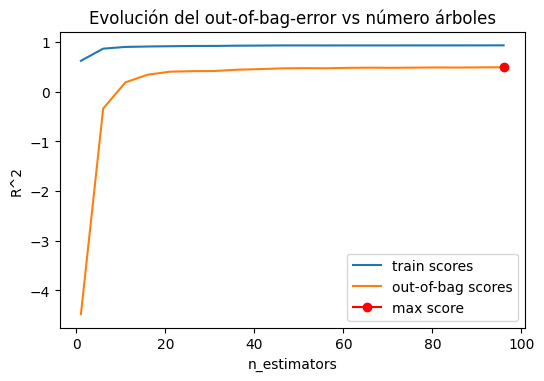

In [21]:
# Validación empleando el Out-of-Bag error : 

# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 100, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.

for n_estimators in estimator_range:
    
    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error
                max_depth    = None,
                max_features = 'sqrt',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_Completo, y_Completo)
    train_scores.append(modelRF.score(X_Completo, y_Completo))
    oob_scores.append(modelRF.oob_score_)
    


# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators(árboles): {estimator_range[np.argmax(oob_scores)]}")

Valor óptimo de n_estimators: 96


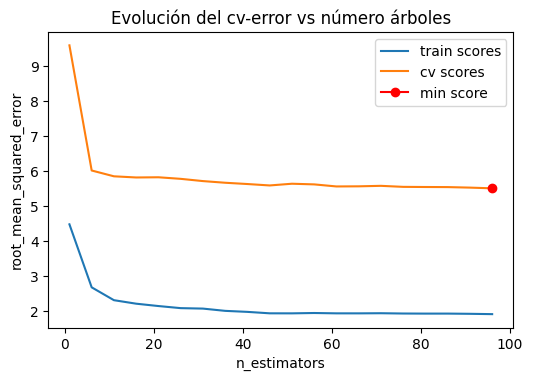

In [22]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 100, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error: mse
                max_depth    = None,
                max_features = 'sqrt',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelRF.fit(X_Completo, y_Completo)
    predicciones = modelRF.predict(X = X_Completo)
    rmse = mean_squared_error(
            y_true  = y_Completo,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelRF,
                X         = X_Completo,
                y         = y_Completo,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Valor óptimo de max_features: 17


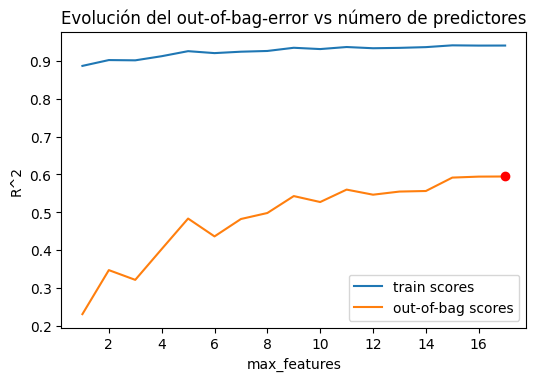

In [23]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_Completo.shape[1] + 1, 1) #X_train.shape[1] = total de características


# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelRF = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_Completo, y_Completo)
    train_scores.append(modelRF.score(X_Completo, y_Completo))
    oob_scores.append(modelRF.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend()
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

Valor óptimo de max_features: 17


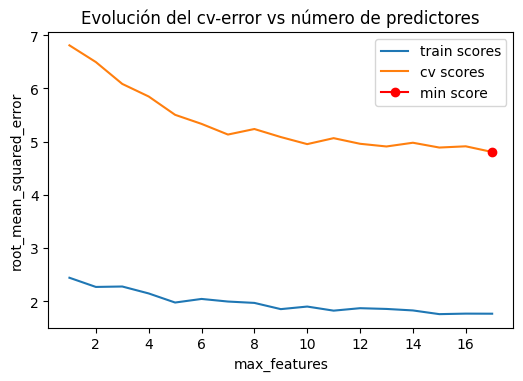

In [24]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_Completo.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelRF = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelRF.fit(X_Completo, y_Completo)
    predicciones = modelRF.predict(X = X_Completo)
    rmse = mean_squared_error(
            y_true  = y_Completo,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelRF,
                X         = X_Completo,
                y         = y_Completo,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend()
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

In [25]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [15, 20, 25],
                 'max_features': [7, 9, 11, 12],
                 'max_depth'   : [3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelRF = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelRF.fit(X_Completo, y_Completo)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelRF.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(5)

Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 25} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 15} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 20} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 25} ✓
M

,oob_r2,max_depth,max_features,n_estimators
32,0.564652,20,11,25
20,0.562304,10,11,25
31,0.560295,20,11,20
35,0.558455,20,12,25
29,0.554356,20,9,25


In [26]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.5646524997043894 R2


In [27]:
#Se entrena el modelo con múltiples hiperparámetros buscando el mejor


# Definir el modelo AdaBoostRegressor
modelRF = RandomForestRegressor(random_state = 123)


CV = 10


parameters =  {
                'n_estimators': [15, 20, 25],
                'max_features': [9, 10, 11, 12],
                'max_depth'   : [3, 10, 20]
                }

grid_RF = GridSearchCV(
                    estimator  = modelRF,
                    param_grid = parameters,
                    scoring    =  'r2',         #'neg_root_mean_squared_error',
                    n_jobs     = - 1,
                    cv         = CV, 
                    refit      = True,
                    verbose    = 3,
                    return_train_score = True
                   )

grid_RF.fit(X = X_Completo, y = y_Completo)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [3, 10, 20],
                         'max_features': [9, 10, 11, 12],
                         'n_estimators': [15, 20, 25]},
             return_train_score=True, scoring='r2', verbose=3)

In [28]:
# Resultados
resultados = pd.DataFrame(grid_RF.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
23,10,12,25,0.326468,0.232066,0.917080,0.003417
35,20,12,25,0.324318,0.238407,0.939974,0.002851
21,10,12,15,0.323790,0.231218,0.909619,0.004079
34,20,12,20,0.320210,0.225197,0.935992,0.002835


In [29]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)


# Obtener los resultados del grid search
results_grid_RF = pd.DataFrame(grid_RF.cv_results_)


# Seleccionar las columnas deseadas
columns_grid_RF = ['param_max_depth']  + \
                    ['param_max_features']  + \
                    ['param_n_estimators']  + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_RF_filtered = results_grid_RF[columns_grid_RF]

# Crear la columna scoreWithStd: f1 / std
results_grid_RF_filtered['scoreWithStd'] = results_grid_RF_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_RF_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
results_grid_RF_filtered[['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]


,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
0,3,9,15,0.0649,0.2821,0.2300
1,3,9,20,0.0781,0.2656,0.2941
2,3,9,25,0.1175,0.2712,0.4332
3,3,10,15,0.1004,0.3193,0.3144
4,3,10,20,0.0973,0.3040,0.3200
5,3,10,25,0.1046,0.2978,0.3513
6,3,11,15,0.1163,0.2938,0.3959
7,3,11,20,0.1118,0.2928,0.3819
8,3,11,25,0.1369,0.2908,0.4708
9,3,12,15,0.1711,0.2841,0.6024


In [30]:
# Se identifican los mejores hiperparámetros
best_params = grid_RF.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'max_depth': 10, 'max_features': 12, 'n_estimators': 25}


In [31]:
# Top 3 de los mejores scores
results_grid_RF_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
34,20,12,20,0.3202,0.2252,1.4219
23,10,12,25,0.3265,0.2321,1.4068
22,10,12,20,0.3200,0.2277,1.4056


In [32]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_RF_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_max_depth      20.0000
param_max_features   12.0000
param_n_estimators   20.0000
mean_test_score       0.3202
std_test_score        0.2252
split0_test_score     0.3906
split1_test_score     0.6618
split2_test_score     0.2539
split3_test_score     0.2054
split4_test_score     0.2453
split5_test_score    -0.1532
split6_test_score     0.2946
split7_test_score     0.4517
split8_test_score     0.6472
split9_test_score     0.2048
scoreWithStd          1.4219
Name: 34, dtype: float64

In [33]:
results_grid_RF_filtered.loc[indice_max_scoreWithStd]['mean_test_score']

np.float64(0.32021039895346054)

In [34]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros 
modelRF = RandomForestRegressor( max_depth = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_max_depth"])
                               , max_features = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_max_features"])
                               , n_estimators = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_n_estimators"])
                               , random_state = 1234)


#Se entrena el modelo con los datos completos
modelRF.fit(X_Completo, y_Completo)

RandomForestRegressor(max_depth=20, max_features=12, n_estimators=20,
                      random_state=1234)

In [35]:
importancia_predictores = pd.DataFrame(
                            {'predictor': dataSetCalidadAire.drop(columns = "pm25").columns,
                             'importancia': modelRF.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

ValueError: All arrays must be of the same length